In [2]:
import os
import random

import numpy as np
import torch
from skimage.io import imread
from torch.utils.data import Dataset
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [7]:
def gray2rgb(image):
    w, h = image.shape
    image += np.abs(np.min(image))
    image_max = np.abs(np.max(image))
    if image_max > 0:
        image /= image_max
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 2] = ret[:, :, 1] = ret[:, :, 0] = image * 255
    return ret


def outline(image, mask, color):
    mask = np.round(mask)
    yy, xx = np.nonzero(mask)
    for y, x in zip(yy, xx):
        if 0.0 < np.mean(mask[max(0, y - 1) : y + 2, max(0, x - 1) : x + 2]) < 1.0:
            image[max(0, y) : y + 1, max(0, x) : x + 1] = color
    return image


def log_images(x, y_true, y_pred, channel=1):
    images = []
    x_np = x.cpu().numpy()[:, channel]
    y_true_np = y_true.cpu().numpy()[:, 0]
    y_pred_np = y_pred.cpu().numpy()[:, 0]
    for i in range(x_np.shape[0]):
        image = gray2rgb(np.squeeze(x_np[i]))
        image = outline(image, y_pred_np[i], color=[255, 0, 0])
        image = outline(image, y_true_np[i], color=[0, 255, 0])
        images.append(image)
    return images

Let's find images with abnormalities!

In [8]:
images_with_abnormalities = []
masks_with_abnormalities = []
for i in range(1, 24):
    mask = imread(
        f"../lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_{i}_mask.tif"
    )
    image = imread(
        f"../lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_{i}.tif"
    )
    if mask.sum() > 0:  # Check if there is some segment in mask
        images_with_abnormalities.append(image)
        masks_with_abnormalities.append(mask)

Print `mask` on original image as an outline

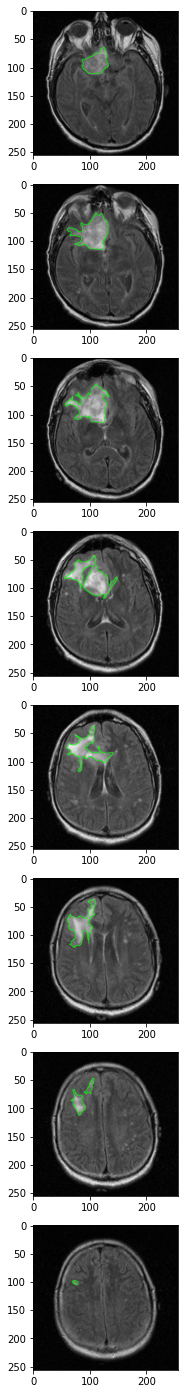

In [9]:
max_plots = 10
_, ax = plt.subplots(len(images_with_abnormalities[:max_plots]), 1, figsize=(5, 25))

for idx, (im, mask) in enumerate(
    zip(images_with_abnormalities[:max_plots], masks_with_abnormalities[:max_plots])
):
    im_t = torch.tensor(im)
    mask_t = torch.tensor(mask).unsqueeze(-1)
    # fix dimensions (C, H, W)
    im_t = im_t.permute(2, 0, 1)
    mask_t = mask_t.permute(2, 0, 1)
    im_t = im_t.unsqueeze(0)
    mask_t = mask_t.unsqueeze(0)

    im_t = im_t.to(torch.float) / 255.0
    mask_t = mask_t.to(torch.float) / 255.0
    outlined_img = log_images(im_t, mask_t, mask_t)

    ax[idx].imshow(outlined_img[0])

In [10]:
df = pd.read_csv("../kaggle_3m/data.csv")

In [11]:
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [13]:
seed = 42
patient_folders = list(
    filter(
        lambda name: name.name not in ["README.md", "data.csv"],
        os.scandir("../kaggle_3m"),
    )
)
random.seed(seed)
validation_cases = 10
validation_patients = random.sample(patient_folders, k=validation_cases)

In [14]:
validation_patients

[<DirEntry 'TCGA_HT_7616_19940813'>,
 <DirEntry 'TCGA_CS_6668_20011025'>,
 <DirEntry 'TCGA_CS_4944_20010208'>,
 <DirEntry 'TCGA_HT_7879_19981009'>,
 <DirEntry 'TCGA_DU_7014_19860618'>,
 <DirEntry 'TCGA_DU_6408_19860521'>,
 <DirEntry 'TCGA_DU_6404_19850629'>,
 <DirEntry 'TCGA_DU_5851_19950428'>,
 <DirEntry 'TCGA_CS_6667_20011105'>,
 <DirEntry 'TCGA_HT_7692_19960724'>]

In [29]:
os.makedirs("./data/valid", exist_ok=True)
os.makedirs("./data/train", exist_ok=True)

In [35]:
from distutils.dir_util import copy_tree

for validation_patient in validation_patients:
    copy_tree(validation_patient.path, "./data/valid/" + validation_patient.name)

In [39]:
cnt = 0
for train_patient in patient_folders:
    if train_patient not in validation_patients:
        cnt += 1
        copy_tree(train_patient.path, "./data/train/" + train_patient.name)